# Отчет

'X', 'Y', 'Month', 'Year',
n_estimators=30, max_depth=10:
2.45973964768

'X', 'Y', 'Month', 'Year', 'Hour'
n_estimators=30, max_depth=10:
2.45612199334

'X', 'Y', 'Month', 'Year', 'Hour'
n_estimators=70, max_depth=15:
2.3770777449

Внезапно, если выкинуть месяц - результат улучшается.
'X', 'Y', 'Month', 'Year', 'Hour'
n_estimators=70, max_depth=15:
2.37622850483

Если выкинуть год но оставить месяц - результат ухудшается.
'X', 'Y', 'Month', 'Year', 'Hour'
n_estimators=70, max_depth=15:
2.39490375842

Если использовать только координаты и час - результат так же ухудшается.
'X', 'Y', 'Hour'
n_estimators=70, max_depth=15:
2.41821809425

Добавление фичи Minutes позволило улучшить результат
'X', 'Y', 'Year', 'Hour', 'Minutes'
n_estimators=70, max_depth=15
2.36959679856

Выкидываем часы и получаем очередно улучшение модели
'X', 'Y', 'Year', 'Minutes'
n_estimators=70, max_depth=15
2.36056042616

######## Новый день, новые тесты
- Увеличиваем кол-во деревье до 80, немного улучшаем показатели модели
'X', 'Y', 'Year', 'Minutes'
n_estimators=300, max_depth=15
2.3467849756212078

Подгоняем max_debth и еще немного улучшаем модель
'X', 'Y', 'Year', 'Minutes'
n_estimators=200, max_depth=17
2.3434 *(отличный тестовый показатель, но сабмит данной модели на Kaggle дает результат хуже чем у модели 70-15)*

n_estimators=300, max_depth=17 почитать не получилось из-за memory error.

На практике результат на Kaggle для модели с 200 деревьями и глубиной 17 оказался хуже чем у прошлой модели.

**На данный момент наилучшие показатели дает модель:**
'X', 'Y', 'Year', 'Minutes'
n_estimators=70, max_depth=15
2.36056042616

######### Третий заход

Добавление информации о Пятнице и подкручивание парамтеров помогло улучшить параметры дерева

'X', 'Y', 'Year', 'Minutes', 'isFriday'
n_estimators=200, max_depth=16
2.34931596509 - *Best*

Похоже стоит построить bag of words из дней недели.

#########
Нормализация по координатам ухудшает модель
2.361

(используются 'X', 'Y', 'Month', 'Year', 'Hour')
При обучении max_depath=10, при количестве деревьев до 70 качество log_loss улучгается (вплоть до 2.4517821589206741), после 70 деревьев показатели ухудшаются.

При обучении n_estimators=30, качество log_loss улучшается до 15, деревьев,  (2.4033074972863218). После 15 деревьев показатели резко ухудшаются.

Совмещая два вышеуказанных показателя (n_estimators=70, max_depth=15) удалось получить: 2.3770777449

Введение переменной Night ухудшает модель (2.39742976255)

Рассчет на 300 деревьях ухудшает результат (2.38157899729)

Попытка построить модель отдельно для Night и отдельно для Day ухудшает модель (2.42175093186 для дня, 2.5 для ночи. Под ночью понималось время > 19 и < 7)

Использование criterion="entropy" вместо "gini" ухудшает модель (2.39547290223 при 70 деревьях)

# San Francisco Crime Data Test Model

In [1]:
# Base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Tools
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
# Metrics
from sklearn.metrics import log_loss
# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
rs = 42 # random_state

In [3]:
data = pd.read_csv('./data/sf_crime/train.csv')

In [4]:
def transform_data(data):
    data['Dates'] = pd.to_datetime(data['Dates'])
    data['Month'] = data['Dates'].apply(lambda i: i.month)
    data['Year'] = data['Dates'].apply(lambda i: i.year)
    data['Hour'] = data['Dates'].apply(lambda i: i.hour)
    data['Minutes'] = data['Dates'].apply(lambda i: \
                                          i.hour*60 + i.minute)

    days_of_week = data['DayOfWeek'].unique()
    for day in days_of_week:
        data[day] = data['DayOfWeek'].apply(lambda curr_day: curr_day == day)
    
    districts = data['PdDistrict'].unique()
    for dist in districts:
        data[dist] = data['PdDistrict'].apply(lambda curr_dist: curr_dist == dist)
    
    categorycal_cols = ['Category', 'Descript', 'DayOfWeek', 'PdDistrict',
                        'Resolution', 'Address', 'Night']
    for category in categorycal_cols:
        if category in data:
            data[category] = data[category].astype('category')
    
#     remove_cat = ['PORNOGRAPHY/OBSCENE MAT', 'TREA']
#     for cat in remove_cat:
#         data = data[data['Category']!=cat]
    
    return data

def split_data(X, y):
    return train_test_split(X, y, test_size=0.3, random_state=42)


def to_ans_format(proba, start_id):
    ans = []
    for id in xrange(len(proba)):
        row = list(proba[id])
        row = [start_id + id] + row
        ans.append(row)
    ans = pd.DataFrame(ans)
    ans.columns = ['Id'] + list(clf.classes_)
    return ans


def submit_partial(clf, nrows, path_to_data, path_to_ans):
    chunk_size = 100000
    done = 0
    first_iter = True
    open(path_to_ans, 'w+').close()
    while done < nrows:
        print('Done: {0}/{1}'.format(done, nrows))
        test_data = pd.read_csv('./data/sf_crime/test.csv',
                                skiprows=xrange(1, done+1), # 1 - to read header
                                nrows=chunk_size)
        start_id = test_data['Id'][0]
        done += chunk_size
        print('start id: ', start_id)
        test_data = transform_data(test_data)
        test_data = test_data[['X', 'Y', 'Year', 'Hour', 'Friday']]
        proba = clf.predict_proba(test_data)
        ans = to_ans_format(proba, start_id)
        ans.to_csv('./data/sf_crime/res.csv', mode='a', index=False,
                  header=first_iter)
        first_iter = False
    print('Done')

In [7]:
data = transform_data(data)

In [46]:
data.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Month,...,NORTHERN,PARK,INGLESIDE,BAYVIEW,RICHMOND,CENTRAL,TARAVAL,TENDERLOIN,MISSION,SOUTHERN
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,5,...,True,False,False,False,False,False,False,False,False,False
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,5,...,True,False,False,False,False,False,False,False,False,False


### Random forest

In [53]:
days_of_week = list(data['DayOfWeek'].unique())
districts = list(data['PdDistrict'].unique())
y = data['Category']
X = data[['X', 'Y', 'Year', 'Minutes']]
X_train, X_test, y_train, y_test = split_data(X, y)

clf = RandomForestClassifier(n_estimators=70, max_depth=16, n_jobs=4,
                             random_state=rs, verbose=True)

clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)
loss = log_loss(y_test, proba)

print(loss)

print('Done')

# 2.36056042616
# 2.34931596509 ("Friday")

[Parallel(n_jobs=4)]: Done   1 out of  70 | elapsed:    2.1s remaining:  2.5min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:   39.0s finished
[Parallel(n_jobs=4)]: Done   1 out of  70 | elapsed:    0.1s remaining:   14.3s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    3.2s finished


2.36107152917
Done


In [13]:
# Submit
X = data[['X', 'Y', 'Year', 'Hour', 'Friday']]
y = data['Category']
clf = RandomForestClassifier(n_estimators=100, max_depth=16, n_jobs=4,
                             random_state=rs, verbose=True)
clf.fit(X, y)

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    1.8s remaining:  3.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   48.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=42, verbose=True,
            warm_start=False)

In [11]:
df = pd.read_csv('./data/sf_crime/test.csv')
nrows = df.shape[0]
del(df)

In [14]:
submit_partial(clf, nrows, './data/sf_crime/test.csv',
               './data/sf_crime/res.csv')

Done: 0/884262
('start id: ', 0)

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    6.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished



Done: 100000/884262
('start id: ', 100000)

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    6.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished



Done: 200000/884262
('start id: ', 200000)

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    7.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished



Done: 300000/884262
('start id: ', 300000)

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    6.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished



Done: 400000/884262
('start id: ', 400000)

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    6.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished



Done: 500000/884262
('start id: ', 500000)

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    6.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished



Done: 600000/884262
('start id: ', 600000)

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    6.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished



Done: 700000/884262
('start id: ', 700000)

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    7.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished



Done: 800000/884262
('start id: ', 800000)

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    6.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished



Done


In [15]:
test_data = pd.read_csv('./data/sf_crime/test.csv')
test_data = transform_data(test_data)
test_data = test_data[['X', 'Y', 'Year', 'Hour', 'Friday']]

In [ ]:
proba = clf.predict_proba(test_data)

In [ ]:
ans = []

for id in xrange(len(proba)):
    row = list(proba[id])
    row = [id] + row
    ans.append(row)

ans = pd.DataFrame(ans)
ans.columns = ['Id'] + list(clf.classes_)

In [24]:
ans.to_csv('./data/sf_crime/res.csv', index=False)

## Все что ниже - тесты

In [179]:
# Попробуем отдельно попредсказывать для лета и зимы
summer_data = data[(data['Month']==6) |
                   (data['Month']==7) |
                   (data['Month']==8)]
y = summer_data['Category']
X = summer_data[['X', 'Y', 'Year', 'Minutes']]
X_train, X_test, y_train, y_test = split_data(X, y)


clf = RandomForestClassifier(n_estimators=300, max_depth=14, n_jobs=4,
                             random_state=rs, verbose=True)
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)
loss = log_loss(y_test, proba)
print(d, loss)

# 14 деревьев - оптимально
# Для лета (month=6,7,8)     
# n=300, max_debth=14
# 300, 2.3849

# Для зимы (month=12,1,2)
# n=300, max_debth=14, 2.396

[Parallel(n_jobs=4)]: Done   1 out of 300 | elapsed:    0.1s remaining:  1.1min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Done   1 out of 300 | elapsed:    0.0s remaining:   12.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    2.6s finished


(20, 2.3854960849457894)


In [148]:
night_data = data[data['Night'] == 0]
y = night_data['Category']
X = night_data[['X', 'Y', 'Month', 'Year', 'Hour']]
X_train, X_test, y_train, y_test = split_data(X, y)

clf = RandomForestClassifier(n_estimators=30, max_depth=10, n_jobs=4,
                             random_state=rs, verbose=True)
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)
loss = log_loss(y_test, proba)
print(loss)


[Parallel(n_jobs=4)]: Done   1 out of  30 | elapsed:    0.6s remaining:   19.3s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Done   1 out of  30 | elapsed:    0.0s remaining:    2.7s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.5s finished


2.42175093186


### Clasterization

In [51]:
from sklearn.cluster import KMeans
y = data['Category']#.cat.codes
X = data[['X', 'Y']] # 'Year',  'Minutes'

In [53]:
# X['Year'] = scale(X['Year'].astype('float64'))
# X['Minutes'] = scale(X['Minutes'].astype('float64'))
X['X'] = scale(X['X'])
X['Y'] = scale(X['Y'])

D:\soft\dev\anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\soft\dev\anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [54]:
clusters = KMeans(n_clusters=5, random_state=rs).fit_predict(X)

In [56]:
clusters

array([0, 0, 0, ..., 4, 4, 4])

In [66]:
cl = map(lambda i: i == 0, clusters)

y = data[cl]['Category']
X = data[cl][['X', 'Y', 'Year', 'Minutes']]

non_trea_ind = (y != 'TREA')
y = y[non_trea_ind]
X = X[non_trea_ind]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42)

In [67]:
clf = RandomForestClassifier(n_estimators=100, max_depth=14, n_jobs=4,
                             random_state=rs, verbose=True)
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)
loss = log_loss(y_test, proba)

print(loss)

# 2.350

# print('Done')

[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.4s remaining:   52.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Done   1 out of 100 | elapsed:    0.0s remaining:    8.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


2.3351149024


С кластеризацией добиться нормальных результатов пока не получилось.
Для одних кластеров результат лучше чем в среднем по больнице, для других хуже.
Основная проблема - из за выпадающих категорий может не работать `log_loss`.

###Logistic regression

In [50]:
from sklearn.linear_model import LogisticRegression

days_of_week = list(data['DayOfWeek'].unique())
districts = list(data['PdDistrict'].unique())
y = data['Category']
X = data[['X', 'Y', 'Year', 'Month', 'Minutes'] + days_of_week + districts]
X_train, X_test, y_train, y_test = split_data(X, y)
X_train, X_test, y_train, y_test = split_data(X, y)

# X['Year'] = scale(X['Year'].astype('float64'))
# X['Minutes'] = scale(X['Minutes'].astype('float64'))
# X['X'] = scale(X['X'])
# X['Y'] = scale(X['Y'])

for c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:

    clf = LogisticRegression(C=c)

    clf.fit(X_train, y_train)
    proba = clf.predict_proba(X_test)
    loss = log_loss(y_test, proba)

    print(c, loss)

    print('Done')

# 2.66622031965 # without normalization and params # normalization gives nothing

(0.0001, 2.64282061928406)
Done
(0.001, 2.6142083341397044)
Done
(0.01, 2.6068572288685887)
Done
(0.1, 2.6057316266290402)
Done
(1, 2.6057240694314618)
Done
(10, 2.6057426474948029)
Done
(100, 2.6057643294970485)
Done
(1000, 2.6057624747942918)
Done
(10000, 2.6057873095379294)
Done


In [8]:
saturday_crimes = data[data['Saturday']]
friday_crimes = data[data['Friday']]

saturday_crimes.groupby(['col1', 'col2'])['col3'].mean()

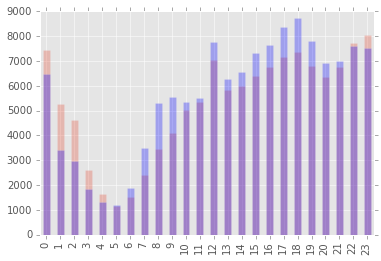

In [25]:
st = saturday_crimes['Hour'].value_counts()
st = st.sort_index()

fr = friday_crimes['Hour'].value_counts()
fr = fr.sort_index()

st.plot(kind='bar', alpha=0.3)
fr.plot(kind='bar', alpha=0.3, color='blue')
plt.show()

In [32]:
data['Category'].value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

# XGBoost tests

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

days_of_week = list(data['DayOfWeek'].unique())
districts = list(data['PdDistrict'].unique())
y = data['Category']
X = data[['X', 'Y', 'Year', 'Minutes']]
X_train, X_test, y_train, y_test = split_data(X, y)

clf = xgb.XGBClassifier(max_depth=10,
                            n_estimators=100,
                            learning_rate=0.05,
                            nthread=4,
                            seed=rs,
                            silent=False)

category_enc = LabelEncoder()
category_enc.fit(data["Category"])
y_train = category_enc.transform(y_train)
y_test = category_enc.transform(y_test)

clf.fit(X_train, y_train, eval_metric='mlogloss',
        early_stopping_rounds=10,
        eval_set=[(X_test, y_test)], verbose=True)

print('Done')

In [30]:
clf.score(X_test, y_test)

0.28381830951160714